# parsing configuration file

In [1]:
import configparser
confParser = configparser.ConfigParser()

In [2]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#--- set dynamic parameters
temp=confParser['parameters']['temperature']
load=confParser['parameters']['load']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


conf. file sections: ['parameters', 'flags', 'neigh list', 'dislocation analysis', 'input files', 'Atomic Radius']


# import libraries

In [3]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch

#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '../../HeaDef/postprocess/utilityy.py'>

In [4]:
class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs
    
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Dump File

In [6]:
!mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
nevery = int(confParser['parameters']['nevery'])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt $nevery 7
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = sys.maxsize, 
                )
print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]



mkdir: cannot create directory ‘dumpFile’: File exists
InputFile= ../simulations/NiCoCrNatom50Kannealed1/Run0/allconf
ERROR: No file column has been mapped to the particle position property.
Traceback (most recent call last):
  File "../../HeaDef/postprocess/OvitosCna.py", line 43, in <module>
    pipeline = io.import_file('%s'%(InputFile), multiple_frames = True)
  File "/home/karimik/opt/ovito-2.9.0-x86_64/bin/../lib/ovito/plugins/python/ovito/io/__init__.py", line 119, in import_file
    if not node.wait(signalError = True):
  File "/home/karimik/opt/ovito-2.9.0-x86_64/bin/../lib/ovito/plugins/python/ovito/__init__.py", line 173, in _ObjectNode_wait
    raise RuntimeError("Data pipeline evaluation failed with the following error: %s" % state.status.text)
RuntimeError: Data pipeline evaluation failed with the following error: No file column has been mapped to the particle position property.
ERROR: The Python script '../../HeaDef/postprocess/OvitosCna.py' has exited with an error.
out

FileNotFoundError: [Errno 2] No such file or directory: 'dumpFile/dump.xyz'

In [296]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


[None, None]

## stress response

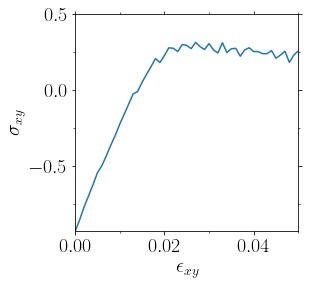

In [29]:
def GetStrsStrain( lmpData, col='sxy' ):

#     fig = plt.figure( figsize = (4,4))
#     ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\epsilon_{xy}$',fontsize=16)
#     ax.set_ylabel(r'$%s$(Gpa)'%col,fontsize=16)
#     ax.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
#     ax.set_xlim(0,0.05)
#     ax.set_ylim(Virial[0],0.5)
#     ax.plot(
# #        sorted(times),
#          0.5*np.array(strainDump),
#         Virial, '-')
#     #
#     plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
#     plt.show()
    #
    return np.array(strainDump), Virial
    
if eval(confParser['flags']['StrsCurve']):
    strain, stress = GetStrsStrain( lmpData,
                  col='sxy',
                 )
    utl.PltErr(0.5*strain,stress,
               attrs={'fmt':'-'},
              xlim=(0,0.05),
               ylim=(stress[0],0.5),
               xstr=r'$\epsilon_{xy}$',
               ystr=r'$\sigma_{xy}$',
               title='stress.png'
              )

## parse data

In [73]:
#itimee=np.sum(list(lmpData.coord_atoms_broken.keys())) #--- only two timesteps:[0,ntime]
itimee=list(lmpData.coord_atoms_broken.keys())[-1] #--- only two timesteps:[0,ntime]
atomsRf = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series') )
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series') )
    #
box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ) )
#box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    
display(pd.DataFrame(atoms.__dict__).head())
pd.DataFrame(atomsRf.__dict__).head()


,x,y,z,id,type,sxx,syy,szz
0,759.118,0.000024,130.658000,1,2,-1.357704,-1.937690,-1.789042
1,759.118,2.053570,2.748980,2,2,0.267779,0.197274,-0.254791
2,759.118,4.107130,1.281910,3,2,-0.176395,-1.471237,-0.523178
3,760.378,2.053570,0.621057,4,3,0.244517,-0.317857,0.456492
4,760.378,4.107130,3.475060,5,1,0.805389,0.239947,1.052140


,x,y,z,id,type,sxx,syy,szz
0,0.00000,0.00000,0.065458,1,2,-1.123136,-0.340794,-0.851273
1,0.00000,2.05355,2.844020,2,2,-1.780600,1.228752,1.590494
2,0.00000,4.10711,1.376950,3,2,-0.147734,-0.540406,1.601411
3,1.25962,2.05355,0.716095,4,3,0.144675,-0.449206,-0.448972
4,1.25962,4.10711,3.570100,5,1,-0.122598,-0.171723,-1.372653


# Displacements

In [41]:
def WrapperDisp(lmpData,reference_frames,current_frames):
    '''
    invoke disp analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lpp.WriteDumpFile(atom_current, box).Write('disp/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        lpp.WriteDumpFile(atom_reference, box0).Write('disp/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'disp/dump_curr.xyz'
        fileRef = 'disp/dump_ref.xyz'
        output = 'disp/disp.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 8 %s'%(lib_path,fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> disp/disp.xyz;rm %s'%(output,output))
        
        
        

!mkdir disp

#--- fetch parameters
nevery = int(confParser['parameters']['nevery'])
lib_path = confParser['input files']['lib_path']
outpt = 'disp/disp.xyz'
!rm $outpt

current_frames = np.array(list(lmpData.coord_atoms_broken.keys()))[::2] #--- ignore half steps
current_frames.sort()
print('current_frames=',current_frames)
#--- reference
reference_frames = [current_frames[0]]*len(current_frames)
print('reference_frames=',reference_frames)
    
    
#--- call ovito
WrapperDisp(lmpData,reference_frames,current_frames)


#--- parse dump files
print('parsing %s'%(outpt))
lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpDisp.GetCords( ncount = sys.maxsize )
display(lmpDisp.coord_atoms_broken[0].head())


mkdir: disp: File exists
current_frames= [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100]
reference_frames= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFi

,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,3,1.937813,34.027512,28.686232,0.0,0.0,0.0
1,2,1,37.510273,30.500498,35.775292,0.0,0.0,0.0
2,3,2,48.227886,26.939295,46.466610,0.0,0.0,0.0
3,4,1,48.221275,16.247408,21.596024,0.0,0.0,0.0
4,5,2,14.469797,2.033415,51.808704,0.0,0.0,0.0


## msd vs. time

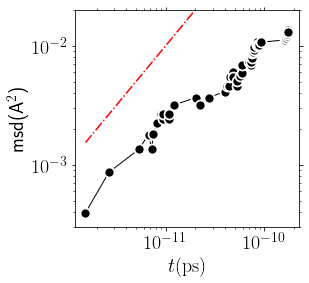

<AxesSubplot:xlabel='$t\\mathrm{(ps)}$', ylabel='msd(A$^2$)'>

In [62]:
!mkdir png
times = list(lmpDisp.coord_atoms_broken.keys())
times.sort()
msd = list(map(lambda x:(lmpDisp.coord_atoms_broken[x]['DisplacementX']**2+\
             lmpDisp.coord_atoms_broken[x]['DisplacementY']**2+\
             lmpDisp.coord_atoms_broken[x]['DisplacementZ']**2).mean(),
        times))

symbols=utl.Symbols()
ax = utl.PltErr(lmpData.times[1:],1e9*lmpData.times[1:],attrs={'fmt':'-.r'},Plot=False)
utl.PltErr(lmpData.times[1:],msd[1:],
          xscale='log',
          yscale='log',
          attrs=symbols.GetAttrs(count=0),
           ax=ax,
           ylim=(3e-4,2e-2),
           xstr=r'$t\mathrm{(s)}$',
           ystr=r'msd(A$^2$)',
           title='png/msd.png'
          )

# Voronoi Analysis